<a href="https://colab.research.google.com/github/shritimukherjee27/geotask/blob/main/geotask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project the data used is from Google Earth Engine, User must provide with three inputs
  

1.   Geojson
2.   Start and End Date
3.   Interval of images

****************************************************************************


In [ ]:
#   Make sure to install geemap and geojson libraries
# !pip install geemap
# !pip install geojson


Let's input geojson data,start date end,date and interval. For uploading gojson data click on the folder icon on the left panel and copy the relative path

In [420]:
start_date=1985
end_date= 2025
interval=5
geojson_data='/content/map.geojson'


Importing libraries


In [421]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geojson
import geemap
import ipywidgets as widgets
import ee


Give all the permissions when pop up appears

In [422]:
ee.Authenticate()

True

Got to the link https://console.cloud.google.com/

- Check the url  for example https://console.cloud.google.com/welcome?project=geotask-424116

- Copy the project id (i.e.project=geotask-424116)

In [423]:
ee.Initialize(project='geotask-424116')

This step reads the geojson file

In [424]:
with open(geojson_data) as f:
    geojson_data = geojson.load(f)


- True colour composite of landsat 457 has same combination and for landsat8 its 432 combination
- These are the visualization parameters which will zoom to the location and the location is defined here.

In [425]:
vis_param_L457 = {'min': 0, 'max': 30000, 'bands': ['SR_B3', 'SR_B2', 'SR_B1']} # for landsat raw image visualization
sc_vis_param_L457 = {'min':0, 'max':0.3, 'bands': ['SR_B3', 'SR_B2', 'SR_B1']} # for scaled landsat image visualization

vis_param_L8 = {'min': 0, 'max': 30000, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']} # for landsat raw image visualization
sc_vis_param_L8 = {'min':0, 'max':0.3, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']} # for scaled landsat image visualization

zoom = 14
width="40%"
center = [12.935079, 77.669476]


Coordinates for the region of interest

In [426]:
aoi = ee.Geometry.Polygon(geojson_data['features'][0]['geometry']['coordinates'], None, False)
display(aoi)

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              77.625121,
              12.957113
            ],
            [
              77.625121,
              12.902361
            ],
            [
              77.690063,
              12.902361
            ],
            [
              77.690063,
              12.957113
            ],
            [
              77.625121,
              12.957113
            ]
          ]
        ]
      },
      "geodesic": {
        "constantValue": false
      }
    }
  }
})

This step the cloud from the image is being removed

  - https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products#:~:text=Landsat%20Collection%202%20surface%20temperature,the%20scale%20factor%20is%20applied.

  From here we can take the scale factor and additive offset value which helps to get the data to its orginal state that is floating value.
  - qa mask helps to elemenate the 0 values

In [427]:
##  Cloud masking algorithms for Landsat 4, 5, 7 surface reflectance
def maskL457sr(image):
  qaMask = image.select('QA_PIXEL').bitwiseAnd(ee.Number.parse('11111', 2)).eq(0).rename("QA_MASK")
  saturationMask = image.select('QA_RADSAT').eq(0)    # The QA_RADSAT band indicates which sensor band(s) are saturated.presence of cloud or bad saturation

  # Apply the scaling factors to the appropriate bands.
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B6').multiply(0.00341802).add(149.0)

  # Replace the original bands with the scaled ones and apply the masks.
  return image.addBands(opticalBands, None, True) \
              .addBands(thermalBands, None, True)  \
              .updateMask(qaMask) \
              .updateMask(saturationMask)


#  Cloud masking algorithms for Landsat 8 surface reflectance
def maskL8sr(image):
  qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111',2)).eq(0).rename("QA_MASK")
  saturationMask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

  # Replace the original bands with the scaled ones and apply the masks.
  return image.addBands(opticalBands, None, True) \
              .addBands(thermalBands, None, True)  \
              .updateMask(qaMask) \
              .updateMask(saturationMask)

In [428]:
## TEST
L5Col_test = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
                .filterDate('1995-01-01', '1995-06-20') \
                .filterBounds(aoi) \
                .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
                .map(algorithm=maskL457sr) \
                .median()

Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(L5Col_test, sc_vis_param_L457, name="TEST")
Map

Map(center=[12.935079, 77.669476], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [429]:
def MaskWaterFunc(image, blueBand, greenBand, redBand,  nirBand, swirBand):  # image is median aggregiated single image from the collection, not data of type ImageCollection!!!
  MNDWI = image.expression(
      '((greenBand - swirBand) / (greenBand + swirBand))',
        {
          'greenBand': image.select(greenBand),
          'swirBand': image.select(swirBand),
        },
      ).rename("MNDWI")

  NDVI = image.expression(
      '((nirBand - redBand) / (nirBand + redBand))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
        },
      ).rename("NDVI")

  EVI = image.expression(
      '2.5 * ((nirBand - redBand) / (nirBand + 6 * redBand - 7.5 * blueBand + 1))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
          'blueBand': image.select(blueBand),
        },
      ).rename("EVI")

  # Water Body Criteria: EVI < 0.1 and (MNDWI > EVI or MNDWI > NDVI)
  waterBody = EVI.lt(0.1).And(MNDWI.gt(EVI).Or(MNDWI.gt(NDVI)))
  return waterBody.rename("WATER")

In this step we are filtering out the tiles and filtering out tiles having less than 10 percent cloud

In [430]:
# Load ImageCollection from Earth Engine using its asset ID
# For Example, landsat collection on earth engine: https://developers.google.com/earth-engine/datasets/catalog/landsat

L5Col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(aoi).filter(ee.Filter.lt('CLOUD_COVER', 10)) # Landsat 5
L7Col = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").filterBounds(aoi).filter(ee.Filter.lt('CLOUD_COVER', 10)) # Landsat 7
L8Col = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(aoi).filter(ee.Filter.lt('CLOUD_COVER', 10)) # Landsat 8

In [431]:
waterMask = {}

for year in range(start_date, end_date, interval):

  # Years using Landsat-5 image collection
  if year in [1985, 1990, 1995]:
    imgCollection = L5Col.filterDate(f'{int(year)-1}-01-01', f'{int(year)+1}-12-31')    # filter collection by date
    imgCloudMask = imgCollection.map(algorithm=maskL457sr)                              # run cloud masking and scale the pixel values
    imgAgg = imgCloudMask.median().clip(aoi)                                            # aggregate the image and clip over AOI

    display(imgAgg)                                                                     # diplay "imgAgg" image properties for each year's image
    key = f'waterMask_{year}'                                                           # initialize key

    # Apply Extract Water Mask Algorithm to the images.
    waterBody = MaskWaterFunc(imgAgg, blueBand = 'SR_B1', greenBand = 'SR_B2', redBand = 'SR_B3', nirBand = 'SR_B4', swirBand = 'SR_B5')  # Run MaskWaterFunc algorithm to mask water bodies
    waterMask[key]=[imgAgg, waterBody]                                                  # save satellite image, and water body mask into dictionary

  # Years using Landsat-7 image collection
  if year in [2000, 2005, 2010]:
    imgCollection = L7Col.filterDate(f'{int(year)-1}-01-01', f'{int(year)+1}-12-31')
    imgCloudMask = imgCollection.map(algorithm=maskL457sr)
    imgAgg = imgCloudMask.median().clip(aoi)
    key = f'waterMask_{year}'
    display(imgAgg)
    waterMask[key]=[imgAgg, MaskWaterFunc(imgAgg, blueBand = 'SR_B1', greenBand = 'SR_B2', redBand = 'SR_B3', nirBand = 'SR_B4', swirBand = 'SR_B5')]

  # Years using Landsat-8 image collection
  if year in [2015, 2020]:
    imgCollection = L8Col.filterDate(f'{int(year)-1}-01-01', f'{int(year)+1}-12-31')
    imgCloudMask = imgCollection.map(algorithm=maskL8sr)
    imgAgg = imgCloudMask.median().clip(aoi)
    key = f'waterMask_{year}'
    display(imgAgg)
    waterMask[key]=[imgAgg, MaskWaterFunc(imgAgg, blueBand = 'SR_B2', greenBand = 'SR_B3', redBand = 'SR_B4', nirBand = 'SR_B5', swirBand = 'SR_B6')]

In [432]:
def MaskWaterFunc_TEST(image, blueBand, greenBand, redBand,  nirBand, swirBand):  # image is median aggregiated single image from the collection, not data of type ImageCollection!!!
  MNDWI = image.expression(
      '((greenBand - swirBand) / (greenBand + swirBand))',
        {
          'greenBand': image.select(greenBand),
          'swirBand': image.select(swirBand),
        },
      ).rename("MNDWI")

  NDVI = image.expression(
      '((nirBand - redBand) / (nirBand + redBand))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
        },
      ).rename("NDVI")

  EVI = image.expression(
      '2.5 * ((nirBand - redBand) / (nirBand + 6 * redBand - 7.5 * blueBand + 1))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
          'blueBand': image.select(blueBand),
        },
      ).rename("EVI")

  # Water Body Criteria: EVI < 0.1 and (MNDWI > EVI or MNDWI > NDVI)
  waterBody = EVI.lt(0.1).And(MNDWI.gt(EVI).Or(MNDWI.gt(NDVI)))

  # Return all data for testing purpose
  return waterBody.rename("WATER"), MNDWI.rename("MNDWI"), NDVI.rename("NDVI"), EVI.rename("EVI")


In [433]:
L5Col_test = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
                .filterDate('1995-01-01', '1995-05-11') \
                .filterBounds(aoi) \
                .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
                .map(algorithm=maskL457sr) \
                .median()  \
                .clip(aoi)

# display(L5Col_test)

# Apply Extract Water Mask Algorithm to the images.
waterBody, mndwi, ndvi, evi = MaskWaterFunc_TEST(L5Col_test, blueBand = 'SR_B1', greenBand = 'SR_B2', redBand = 'SR_B3', nirBand = 'SR_B4', swirBand = 'SR_B5')



In [434]:
L5Col_test


In [435]:

# Visualize all Layers
Map = geemap.Map(center = center, zoom = zoom, width = width)

Map.addLayer(L5Col_test, sc_vis_param_L457, name="L8 data")
Map.addLayer(waterBody, name="Water Body")
Map.addLayer(ndvi,{'min': -1, 'max': 1, 'palette': 'Greens'}, name="NDVI")
Map.addLayer(mndwi, {'min': -1, 'max': 1, 'palette': 'Blues'}, name="MNDWI")
Map.addLayer(evi, {'min': -1, 'max': 1, 'palette': 'turbo'}, name="EVI")

Map

Map(center=[12.935079, 77.669476], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [436]:

# Apply Extract Water Mask Algorithm to the images.
waterBody, mndwi, ndvi, evi = MaskWaterFunc_TEST(L5Col_test, blueBand = 'SR_B1', greenBand = 'SR_B2', redBand = 'SR_B3', nirBand = 'SR_B4', swirBand = 'SR_B5')


In [437]:
waterMask

{'waterMask_1985': [<ee.image.Image at 0x7be3740fe0b0>,
 'waterMask_1990': [<ee.image.Image at 0x7be374104f70>,
 'waterMask_1995': [<ee.image.Image at 0x7be3741071c0>,
 'waterMask_2000': [<ee.image.Image at 0x7be3741110c0>,
 'waterMask_2005': [<ee.image.Image at 0x7be3741131c0>,
 'waterMask_2010': [<ee.image.Image at 0x7be374129360>,
 'waterMask_2015': [<ee.image.Image at 0x7be37412b580>,
 'waterMask_2020': [<ee.image.Image at 0x7be374131600>,
  <ee.image.Image at 0x7be374133310>]}

From the below list choose the mask name

In [438]:
Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(waterMask['waterMask_1995'][0], sc_vis_param_L457, name="Satellite")
Map.addLayer(waterMask['waterMask_1995'][1],{'palette': ['00FFFF', '0000FF']}, name="Water Mask")
Map


Map(center=[12.935079, 77.669476], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [439]:
Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(waterMask['waterMask_2015'][0], sc_vis_param_L457, name="Satellite")
Map.addLayer(waterMask['waterMask_2015'][1],{'palette': ['00FFFF', '0000FF']}, name="Water Mask")
Map

Map(center=[12.935079, 77.669476], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [440]:
# function to calculate area of geometry in sq km. and add property to ee feature.

def add_area_property(feature):
    area = feature.geometry().area(maxError=1).divide(ee.Number(1000000))
    # The maxError=1 is setting the maximum allowable error for the area calculation to be 1 meter.
    return feature.set('area', area)

# Looping through each water mask raster to convert rasters to vector
watermaskVector = {}
for item in list(waterMask.keys()):
  # https://gis.stackexchange.com/a/413138/126926
  wmReduced = waterMask[item][1].reduceNeighborhood(ee.Reducer.mode(), ee.Kernel.circle(5))    # filter operation, to remove isolated pixels
  # Raster to Vector operation
  vectors = ee.Image(wmReduced).selfMask().reduceToVectors(
    geometry=aoi,
    scale= 30,
    eightConnected= True,
    maxPixels= 1e10,
    tileScale= 16
  )

  # calculate area of each vectors
  vectorAreaProp = vectors.map(add_area_property)           # add 'area' property by calculating from geometry
  vectorWaterMask = (vectorAreaProp.sort('area', False))    # sort the features within featureCollection by 'area' property in descending order
  vectorWaterMask = vectorWaterMask.limit(20)               # only top 'n' largest water bodies will be selected
  display(vectorWaterMask)

  # Add to the dictionary
  watermaskVector[item] = vectorWaterMask

On visualization we can see that how drastically the waterbodies have shrinked over the time on clicking on the spanner icon toggle off all the satellite images
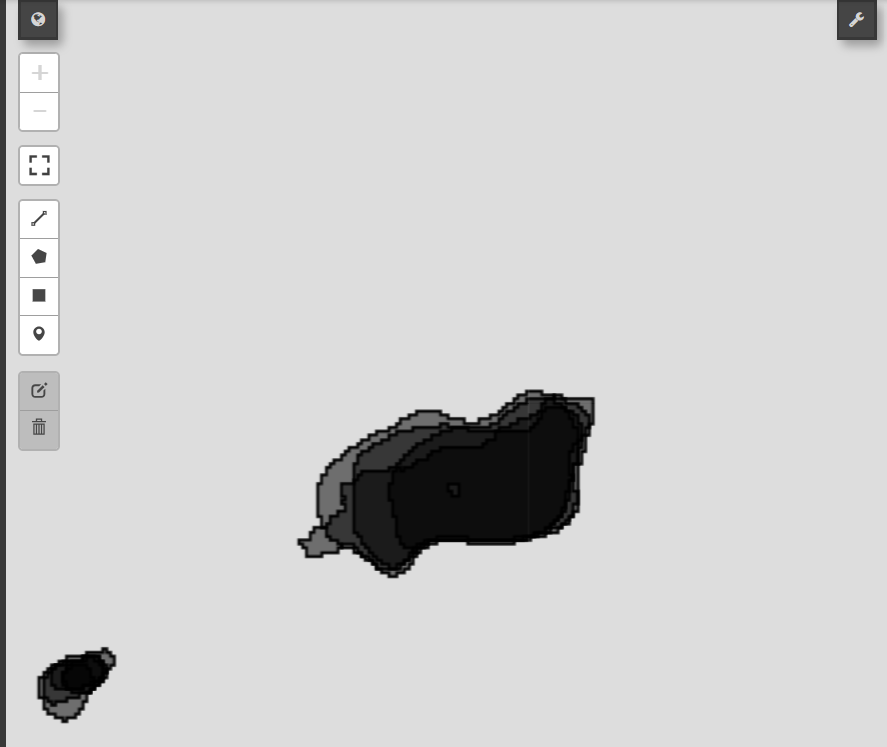

Here we are eliminating values where there is no bands to avoid errors

In this part I am destructuring the variables and creating dictionaries to make sure both dictionaries have same key and elements

In [441]:
def synchronize_dictionaries(dict1, dict2):
    # Get common keys
    common_keys = set(dict1.keys()) & set(dict2.keys())

    # Update dictionaries to contain only common keys
    updated_dict1 = {key: dict1[key] for key in common_keys}
    updated_dict2 = {key: dict2[key] for key in common_keys}

    # Determine original dictionary types and maintain them
    dict1_type = type(dict1)
    dict2_type = type(dict2)

    # Convert dictionaries to their original types with common keys
    synchronized_dict1 = dict1_type(updated_dict1)
    synchronized_dict2 = dict2_type(updated_dict2)

    return synchronized_dict1, synchronized_dict2

In [442]:
waterMask,watermaskVector=synchronize_dictionaries(waterMask, watermaskVector)

In [444]:
# Display the extracted vector water body layer

MapFinal = geemap.Map(center = center, zoom = 14, height="800px", width = "50%")


for layer in watermaskVector:
    # Check if the image has bands before adding layers
    if waterMask[str(layer)][0].bandNames().size().getInfo() > 0:
        MapFinal.addLayer(waterMask[str(layer)][0], sc_vis_param_L457, name=layer.split("_")[1]+"_Landsat")   # satellite image
        MapFinal.addLayer(watermaskVector[layer], name=layer)
    else:
        watermaskVector.pop(layer)

MapFinal


Map(center=[12.935079, 77.669476], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

Here we can check all the watermasks with the band informations

In [445]:
# Demo: Traversing through featureCollection -> feature -> properties

# Take feature collection item
featureCol = watermaskVector['waterMask_2015']
display(featureCol)

# Display feature
feature = featureCol.first()
display(feature)

# Display feature as dictionary
dictx = feature.toDictionary()
display(dictx)

# Display area property
  # dictx.get('area')             # possible way, but not preferred
  # .getInfo() changes the ee.dictionary.Dictionary asset to python dictionary which we can manipulate in our program
dictx.getInfo()['area']

1.0834988276014896

In [446]:
waterArea = []

keys = list(watermaskVector.keys())
print(keys)
for item in keys:
  areaSum = watermaskVector[item].reduceColumns(ee.Reducer.sum(),['area']).get('sum').getInfo()
  waterArea.append(areaSum)

# .reduceColumns(ee.Reducer.sum(),['area']), applies ee.Reducer.sum() to add all 'area' field, and appends a 'sum' attribute in the dataset.
#  We can then retrieve this 'sum' value using .getInfo()

['waterMask_2015', 'waterMask_2005', 'waterMask_2010', 'waterMask_2000', 'waterMask_1995', 'waterMask_1990', 'waterMask_2020']


In [447]:
print(waterArea)

[1.237549491389597, 1.9298306474444682, 1.5447394842793778, 1.8904451214509406, 2.271153870089969, 1.497483316015281, 0.24420170966727217]


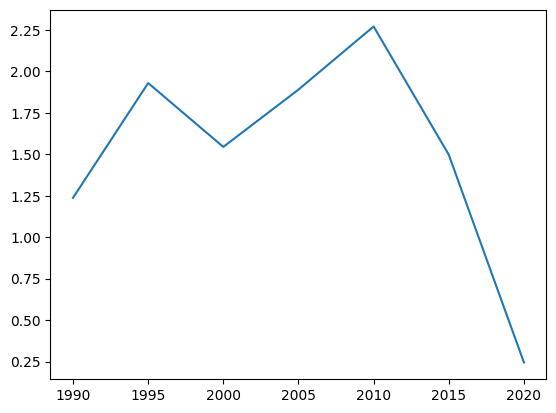

In [448]:
time_frame = list(range(1990, 2025, 5))
plt.plot(time_frame, waterArea)